# Imports
Import modules used in this notebook:

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from data.dataset import ShapeDataset
from network.objdetec import ConvEasy
from network.optimizer import train_loop, test_loop
from matplotlib import pyplot as plt
%matplotlib inline

# Device for training
Check if CUDA is available:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
#device = "cpu"

Using cuda device


# Hyperparameter
- Learning rate
- Batch size
- Epochs

In [3]:
learning_rate = 5e-4
batch_size = 32
epochs = 30

# Dataset
Create dataset

In [4]:
num_obj = 1
num_imgs_train = 100000
num_imgs_val = 10000
num_imgs_test = 10000
img_width, img_height = 32, 32

train_set = ShapeDataset(num_obj, num_imgs_train, img_width, img_height)
val_set = ShapeDataset(num_obj, num_imgs_val, img_width, img_height)
test_set = ShapeDataset(num_obj, num_imgs_test, img_width, img_height)

In [5]:
train_set[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 tensor([[25., 17.,  4., 11.]], dtype=torch.float64))

Look at some dataset examples:

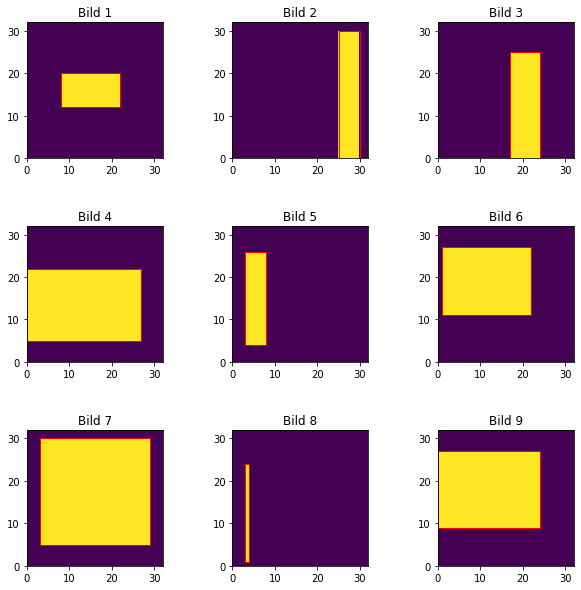

In [6]:
fig = plt.figure(figsize=(10, 10))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    sample_idx = np.random.randint(0, len(train_set) - 1)
    img, label = train_set[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(f"Bild {i}")
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.imshow(img[0].T, origin="lower", extent=[0, img_width, 0, img_height])
    for bbox in label:
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))
plt.show()

# Dataloader
Define Dataloader:

In [7]:
train_dataloader = DataLoader(train_set, batch_size, num_workers=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size, num_workers=16)
test_dataloader = DataLoader(test_set, batch_size, num_workers=16)

Check if the shape of batches is as expected:

In [8]:
fig = plt.figure(figsize=(img_width, img_height))
rows, cols = 3, 3
for batch, (img, label) in enumerate(train_dataloader):
    
    print(img.shape)
    
    if batch >= 3:
        break

torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])


<Figure size 2304x2304 with 0 Axes>

# Model
Define mean squared error loss as loss function:

In [9]:
loss_fn = nn.MSELoss()

Define model and move it to gpu:

In [10]:
model = ConvEasy(num_obj).to(device)
next(model.parameters()).device

device(type='cuda', index=0)

Look at model summary:

In [11]:
summary(model, (1, 1, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ConvEasy                                 --                        --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           832
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Flatten: 2-4                      [1, 6272]                 --
│    └─Linear: 2-5                       [1, 128]                  802,944
│    └─ReLU: 2-6                         [1, 128]                  --
│    └─Linear: 2-7                       [1, 4]                    516
Total params: 804,292
Trainable params: 804,292
Non-trainable params: 0
Total mult-adds (M): 1.46
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 3.22
Estimated Total Size (MB): 3.42

Transform weights of the model to double tensor:

In [12]:
model.double()

ConvEasy(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=6272, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

Check if forwarding of a simple sample works:

In [13]:
model.forward(train_set.data[0].unsqueeze(0).to(device))

tensor([[ 0.0158,  0.0444, -0.0077, -0.1260]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddmmBackward>)

# Optimization Loop
Select an optimizer:

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Check how the NN detects rectancles without any training:

[[ 0.01578754  0.04435614 -0.00774432 -0.12604602]]
[[ 0.01909957  0.01483148  0.00179394 -0.13919029]]
[[ 0.00831295 -0.01082103 -0.04767511 -0.08008296]]
[[ 0.05000435  0.01255254  0.03699026 -0.14031743]]
[[ 0.16497151 -0.00099597  0.00608352 -0.13720561]]
[[ 0.02703913  0.03232631  0.00343466 -0.13659818]]
[[ 0.04448303 -0.02711885 -0.00050177 -0.14498458]]
[[ 0.00360276 -0.03046145 -0.0262361  -0.12080125]]
[[ 0.08133016  0.00473362 -0.0332611  -0.10133068]]


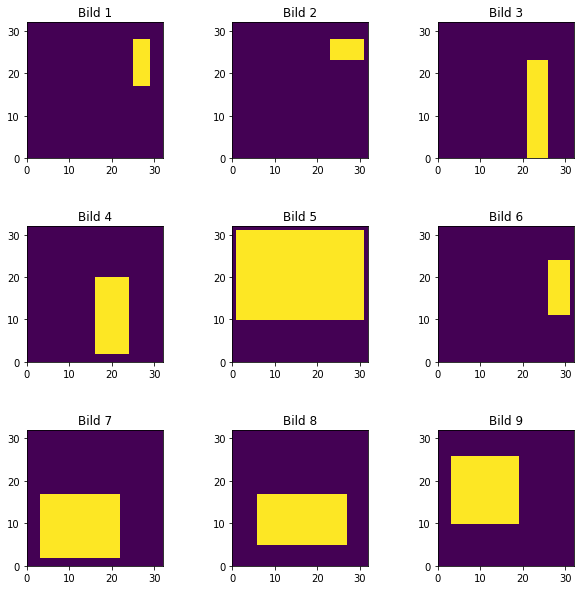

ConvEasy(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=6272, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [15]:
num_samples = 9
fig = plt.figure(figsize=(10, 10))
rows, cols = 3, 3
model.eval()

with torch.no_grad():
    for i, (img, label) in enumerate(train_set):
        pred = model.forward(img.unsqueeze(0).to(device)).cpu().numpy()
        print(pred)
        fig.add_subplot(rows, cols, i+1)
        plt.title(f"Bild {i+1}")
        plt.subplots_adjust(wspace=0.4, hspace=0.5)
        plt.imshow(img.cpu().T, origin="lower", extent=[0, img_width, 0, img_height])
        for bbox in pred:
            plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))
        if i >= num_samples - 1:
            break
    plt.show()
model.train()

Train the CNN:

In [16]:
model.train()
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}\n")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)

-------------------------------
Epoch 1

Train loss: 213.82229186205785]
-------------------------------
Epoch 2

Train loss: 1.4311549319591754]
-------------------------------
Epoch 3

Train loss: 2.39753951243629]
-------------------------------
Epoch 4

Train loss: 0.6027910320508949]
-------------------------------
Epoch 5

Train loss: 0.8350210604025206]
-------------------------------
Epoch 6

Train loss: 0.4798714559273051]
-------------------------------
Epoch 7

Train loss: 0.5426997220720714]
-------------------------------
Epoch 8

Train loss: 0.363016917232474]
-------------------------------
Epoch 9

Train loss: 0.13320908311991933]
-------------------------------
Epoch 10

Train loss: 0.3409879269295386]
-------------------------------
Epoch 11

Train loss: 0.12074122803431409]
-------------------------------
Epoch 12

Train loss: 0.15589198777841923]
-------------------------------
Epoch 13

Train loss: 0.2964277481100097]
-------------------------------
Epoch 14

Train

Check how the NN detects rectancles after training:

[[ 0.24945008  1.31970264 31.28294267  5.48116539]]
[[ 0.08182264  4.33138965 19.9684403  21.67746654]]
[[21.63164471  2.79077734  3.01813847 17.15495897]]
[[18.36571398  0.17438487  7.85051016 30.87230075]]
[[ 1.00233944  2.10610376 19.20901751 17.9008871 ]]
[[ 1.150474   13.38441308 25.26846489 15.66273954]]
[[9.90933145e+00 1.17318165e-02 1.31685858e+01 1.88989517e+01]]
[[10.732029   14.00272313 17.22175901  5.26406494]]
[[1.10129113e-03 5.04927430e+00 1.20647029e+01 2.09073417e+01]]


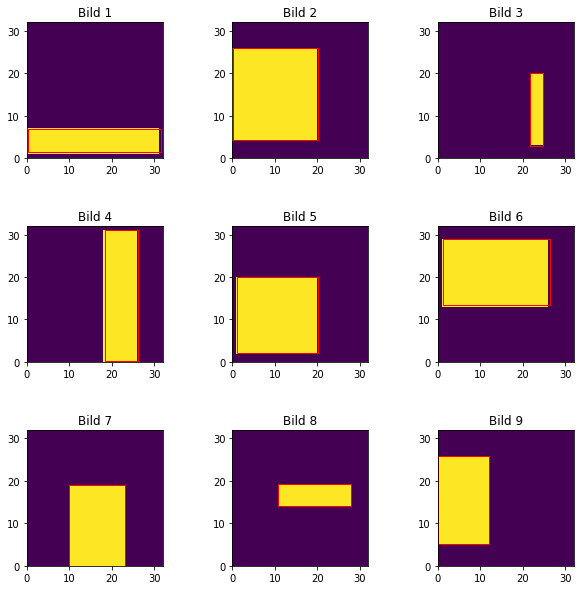

In [17]:
num_samples = 9
fig = plt.figure(figsize=(10, 10))
train_set.to_inplace(device)
rows, cols = 3, 3
model.eval()

with torch.no_grad():
    for i, (img, label) in enumerate(val_set):
        pred = model.forward(img.unsqueeze(0).to(device)).cpu().numpy()
        print(pred)
        fig.add_subplot(rows, cols, i+1)
        plt.title(f"Bild {i+1}")
        plt.subplots_adjust(wspace=0.4, hspace=0.5)
        plt.imshow(img.cpu().T, origin="lower", extent=[0, img_width, 0, img_height])
        for bbox in pred:
            plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))
        if i >= num_samples - 1:
            break
    plt.show()